In [1]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import numpy as np
from IPython.display import YouTubeVideo

import requests
import json

import re
from google.colab import files
from google.colab import drive

import matplotlib.pyplot as plt
from scipy.signal import peak_prominences
from scipy.signal import find_peaks

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = r"/content/drive/MyDrive/Youtube8m/"
vocab = pd.read_csv(path + "vocabulary.csv")
vocab.head()

# categories of video we care about
categories = [8, 13, 14, 324, 807, 834]
categories = [8]
video_records = [path + f'video/{x}' for x in os.listdir(path + f'video/') if 'tfrecord' in x]
frame_records = [path + f'frame/{x}' for x in os.listdir(path + f'frame/') if 'tfrecord' in x]

### Video-level data

In [3]:
vid_ids = []
labels = []

#dataset = tf.data.TFRecordDataset([frame_lvl_record])
dataset = tf.data.TFRecordDataset(video_records)

for example in dataset:
    tf_example = tf.train.Example()
    tf_example.ParseFromString(example.numpy())  # Parse the serialized example

    # Extract 'id' and 'labels' features
    vid_id = tf_example.features.feature['id'].bytes_list.value[0].decode(encoding='UTF-8')
    label = tf_example.features.feature['labels'].int64_list.value  # List of integer labels

    for i in label:
        if i in categories:
            # if this is a label we want to look for
            vid_ids.append(vid_id)
            labels.append(label)
            break

### Read the frame-level data

In [4]:
# Define the feature description to parse the sequence example
def _parse_function(proto):
    # Define the features you want to extract from the SequenceExample
    context_features = {
        'id': tf.io.FixedLenFeature([], tf.string),
    }

    sequence_features = {
        'rgb': tf.io.FixedLenSequenceFeature([], tf.string, allow_missing=True),
        'audio': tf.io.FixedLenSequenceFeature([], tf.string, allow_missing=True),
    }

    # Parse the SequenceExample
    context, sequence = tf.io.parse_single_sequence_example(proto, context_features, sequence_features)

    return context, sequence


feat_rgb = []
feat_audio = []
feat_ids = []

# Create a dataset for reading TFRecords
dataset = tf.data.TFRecordDataset(frame_records)

# Apply the parsing function to the dataset
dataset = dataset.map(_parse_function)

# Read the first video (break after one iteration)
for context, sequence in dataset:


    vid_id = context['id'].numpy().decode('utf-8')
    #if vid_id == 'Vcha':
    #    print("HERE")
    #    pass
    #else:
    #    continue
    #if vid_id not in vid_ids:
    #    print(f"Skipping ViD: {vid_id}")
    #    continue
    print(vid_id)
    n_frames = len(sequence['audio'])  # Assuming audio and rgb have the same number of frames
    rgb_frame = []
    audio_frame = []

    # Iterate through frames (audio and rgb)
    for i in range(n_frames):
        rgb_data = tf.io.decode_raw(sequence['rgb'][i], tf.uint8)
        audio_data = tf.io.decode_raw(sequence['audio'][i], tf.uint8)

        # Convert the raw bytes to float32 tensors
        rgb_frame.append(tf.cast(rgb_data, tf.float32).numpy())  # Use .numpy() to get the actual value
        audio_frame.append(tf.cast(audio_data, tf.float32).numpy())

    # Append the frames to the feature lists
    feat_rgb.append(rgb_frame)
    feat_audio.append(audio_frame)

    # Exit after processing the first video

# Print the features (just for inspection)
print('The first video has %d frames' %len(feat_rgb[0]))
#print("RGB Frames: ", feat_rgb)
#print("Audio Frames: ", feat_audio)


7keh
Hceh
Uceh
hieh
iEeh
3teh
YQeh
VSeh
Mdeh
RFeh
NZeh
ODeh
sGeh
61eh
peeh
NOeh
xPeh
4Ieh
dveh


DataLossError: {{function_node __wrapped__IteratorGetNext_output_types_3_device_/job:localhost/replica:0/task:0/device:CPU:0}} truncated record at 4896931' failed with Read less bytes than requested [Op:IteratorGetNext] name: 

### Exploring this video

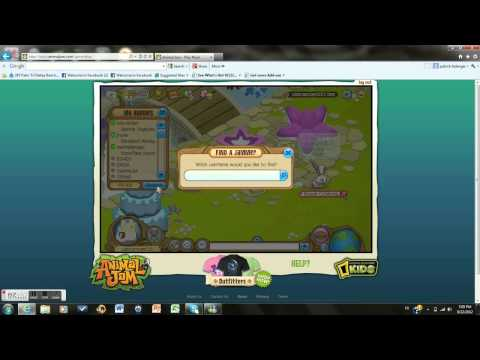

In [5]:
vid_id = '7keh'
content = requests.get('http://data.yt8m.org/2/j/i/{}/{}.js'.format(vid_id[:2], vid_id)).text
match = re.search(r'i\("[^"]+","([^"]+)"\);', content)
match_string = match.group(1)
match_string

YouTubeVideo(match_string)

### Optical Flow Based Segmentation

In [24]:
# Function to calculate the optical flow using Euclidean distance between successive frames
def calculate_optical_flow_euclidean(embedding_seq):
    # Calculate the Euclidean distance between successive frames
    return np.linalg.norm(embedding_seq[1:] - embedding_seq[:-1], axis=1)

# Function to find local maxima and minima, ensuring that they are at least `min_dist` frames apart
def find_local_maxima_minima(flow, num_peaks=10, min_dist=10):
    # Find local maxima (peaks) and minima (valleys) in the optical flow
    maxima, _ = find_peaks(flow)
    minima, _ = find_peaks(-flow)  # Minima are the negative peaks

    # Combine maxima and minima
    all_peaks = np.concatenate((maxima, minima))

    # Sort all detected peaks
    all_peaks_sorted = np.sort(all_peaks)

    # Ensure that peaks are at least `min_dist` apart
    valid_peaks = [all_peaks_sorted[0]]  # Start with the first peak
    for i in range(1, len(all_peaks_sorted)):
        if all_peaks_sorted[i] - valid_peaks[-1] >= min_dist:
            valid_peaks.append(all_peaks_sorted[i])

    # Ensure we return no more than `num_peaks` peaks
    if len(valid_peaks) > num_peaks:
        valid_peaks = valid_peaks[:num_peaks]

    return np.array(valid_peaks)

# Function to create segments based on detected peaks
def create_segments_from_peaks(flow, num_segments=10, min_dist=10):
    # Find local maxima/minima to be used as segment boundaries
    peak_indices = find_local_maxima_minima(flow, num_peaks=num_segments, min_dist=min_dist)

    # Ensure that we always include the start (0) and end (len(flow)) of the video
    segment_boundaries = np.concatenate(([0], peak_indices, [len(flow)]))

    return segment_boundaries


# Function to compute a moving average of the flow
def moving_average(arr, window_size=5):
    """
    Compute the moving average of the given array using a window of size `window_size`.
    """
    return np.convolve(arr, np.ones(window_size) / window_size, mode='valid')

def merge_intervals(arr, minsize):
    # Ensure the array is sorted (if it is not already)
    arr = np.sort(arr)

    merged = [arr[0]]  # Start with the first element

    for i in range(1, len(arr)):
        # If the difference between consecutive elements is less than minsize, merge them
        if arr[i] - merged[-1] < minsize:
            continue  # Skip adding the current element (effectively merging)
        else:
            merged.append(arr[i])  # Otherwise, add the element to the merged list

    return np.array(merged)


def rank_averages(averages):
    # Get the indices that would sort the averages array in descending order
    sorted_indices = np.argsort(averages)[::-1]

    # Create an array to hold the ranks
    ranks = np.zeros_like(sorted_indices) + 1  # Initialize all ranks to 1

    # Assign ranks based on sorted order
    for rank, idx in enumerate(sorted_indices):
        ranks[idx] = rank + 1  # Assign the rank, +1 because ranking starts at 1

    return ranks

import numpy as np

def compute_segment_means(segments, other_array):
    """
    Computes the mean of `other_array` values for each segment defined by `segments`.
    If a segment extends beyond the bounds of `other_array`, the mean will be 0 for that segment.

    Parameters:
    - segments (np.array): Array of segment boundaries (must be in increasing order).
    - other_array (np.array): Array of values to calculate the mean over.

    Returns:
    - List of means for each segment.
    """
    # Length of the other_array
    array_length = len(other_array)

    averages = []

    # Process the middle segments
    for i in range(1, len(segments)):
        start_idx = segments[i-1]
        end_idx = segments[i]

        # Adjust the end index if it's out of bounds
        if end_idx > array_length:
            end_idx = array_length

        # If the range is valid (start < end), compute the mean; else, return 0
        if start_idx < end_idx:
            segment_mean = other_array[start_idx:end_idx].mean()
        else:
            segment_mean = 0

        averages.append(segment_mean)

    return averages

def optical_flow_segments(optical_flow, max_segments=10, min_frames=10):
  # calculate peaks and prominences
  peaks, _ = find_peaks(optical_flow)
  prominences = peak_prominences(optical_flow, peaks)[0]
  prominences = prominences.argsort()
  peak_index = peaks[prominences[-max_segments:]]
  peak_index.sort()

  # merge so they have a minimum distance of min_frames
  peak_index_final = merge_intervals(peak_index, min_frames)
  #peak_index_final.insert(0, 0)
  peak_index_final = np.insert(peak_index_final, 0, 0)
  peak_index_final = np.append(peak_index_final, len(optical_flow))
  return peak_index_final


In [22]:
rgb_frames = np.array(feat_rgb[0])
audio_sample_pos = np.array(feat_audio[0])
audio_sample_neg1 = np.array(feat_audio[1])
audio_sample_neg2 = np.array(feat_audio[2])

# Calculate optical flow using cosine similarity
optical_flow_video = calculate_optical_flow_euclidean(rgb_frames)
optical_flow_video = moving_average(optical_flow_video, window_size=20)

optical_flow_audio_pos = calculate_optical_flow_euclidean(audio_sample_pos)
optical_flow_audio_pos = moving_average(optical_flow_audio_pos, window_size=20)

optical_flow_audio_neg1 = calculate_optical_flow_euclidean(audio_sample_neg1)
optical_flow_audio_neg1 = moving_average(optical_flow_audio_neg1, window_size=20)

optical_flow_audio_neg2 = calculate_optical_flow_euclidean(audio_sample_neg2)
optical_flow_audio_neg2 = moving_average(optical_flow_audio_neg2, window_size=20)

# Segment the video based on regime changes in optical flow
segments = optical_flow_segments(optical_flow_video, max_segments=4)

In [23]:
segments

array([  0,  26,  89, 120, 185, 197])

In [8]:
segment_ranks_video = rank_averages(compute_segment_means(segments, optical_flow_video))
segment_ranks_audio_pos = rank_averages(compute_segment_means(segments, optical_flow_audio_pos))
segment_ranks_audio_neg1 = rank_averages(compute_segment_means(segments, optical_flow_audio_neg1))
segment_ranks_audio_neg2 = rank_averages(compute_segment_means(segments, optical_flow_audio_neg2))

print(segment_ranks_video)
print(segment_ranks_audio_pos)
print(segment_ranks_audio_neg1)
print(segment_ranks_audio_neg2)

norm_diff_pos = round(np.linalg.norm(segment_ranks_video-segment_ranks_audio_pos), 2)
norm_diff_neg1 = round(np.linalg.norm(segment_ranks_video-segment_ranks_audio_neg1), 2)
norm_diff_neg2 = round(np.linalg.norm(segment_ranks_video-segment_ranks_audio_neg2), 2)

print(norm_diff_pos)
print(norm_diff_neg1)
print(norm_diff_neg2)

[4 5 3 2 1]
[2 5 4 3 1]
[3 4 1 2 5]
[5 1 2 4 3]
2.45
4.69
5.1


### Plot Result

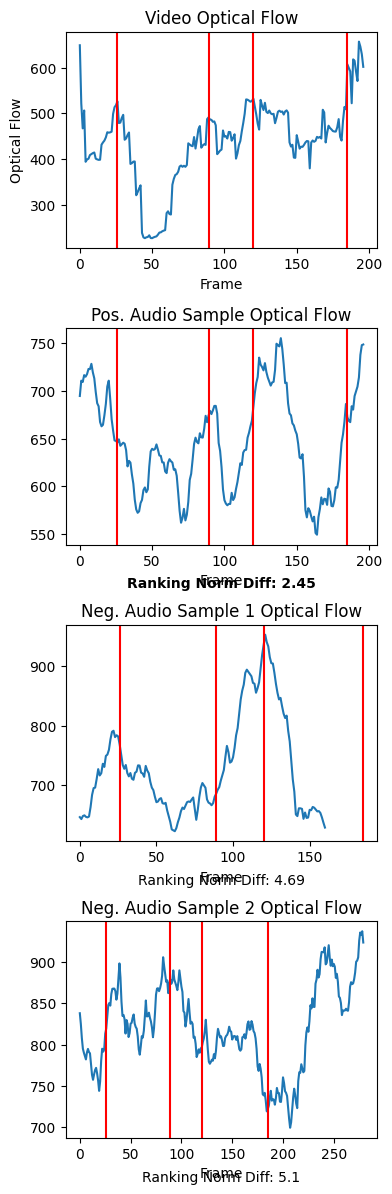

In [190]:
fig, axes = plt.subplots(4, 1, sharey=False, figsize=(4, 12))
axes[0].plot(optical_flow_video)
axes[0].set_title('Video Optical Flow')
axes[0].set_xlabel('Frame')
axes[0].set_ylabel('Optical Flow')

axes[1].plot(optical_flow_audio_pos)
axes[1].set_title('Pos. Audio Sample Optical Flow')
axes[1].set_xlabel('Frame')

axes[2].plot(optical_flow_audio_neg1)
axes[2].set_title('Neg. Audio Sample 1 Optical Flow')
axes[2].set_xlabel('Frame')

axes[3].plot(optical_flow_audio_neg2)
axes[3].set_title('Neg. Audio Sample 2 Optical Flow')
axes[3].set_xlabel('Frame')

for peak in segments:
  axes[0].axvline(peak, ymin=0, ymax=1, color='r')
  axes[1].axvline(peak, ymin=0, ymax=1, color='r')
  axes[2].axvline(peak, ymin=0, ymax=1, color='r')
  axes[3].axvline(peak, ymin=0, ymax=1, color='r')

axes[1].text(0.5, -0.15, f'Ranking Norm Diff: {norm_diff_pos}', ha='center', fontweight='bold', va='top', transform=axes[1].transAxes)
axes[2].text(0.5, -0.15, f'Ranking Norm Diff: {norm_diff_neg1}', ha='center', va='top', transform=axes[2].transAxes)
axes[3].text(0.5, -0.15, f'Ranking Norm Diff: {norm_diff_neg2}', ha='center', va='top', transform=axes[3].transAxes)
#plt.show()
plt.tight_layout(pad=1)
plt.savefig('Segment.png')

[4 5 3 2 1]
[2 5 4 3 1]
[3 4 1 2 5]
[5 1 2 4 3]
2.449489742783178
4.69041575982343
5.0990195135927845


In [167]:
np.linalg.norm(segment_ranks_video-segment_ranks_audio_pos)
np.linalg.norm(segment_ranks_video-segment_ranks_audio_neg)

2.449489742783178

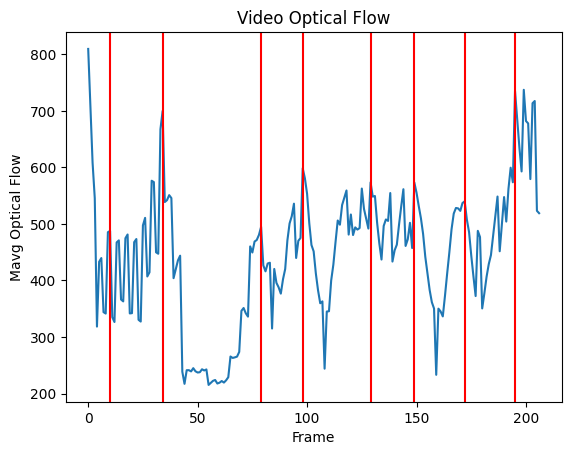

In [47]:
plt.plot(optical_flow)
for peak in peak_index_final:
  plt.axvline(peak, ymin=0, ymax=1, color='r')
plt.title('Video Optical Flow')
plt.xlabel('Frame')
plt.ylabel('Mavg Optical Flow')
plt.show()

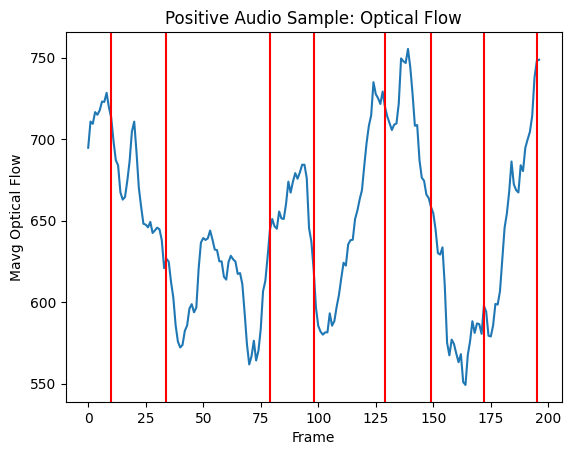

In [56]:


plt.plot(optical_flow_audio)
for peak in peak_index_final:
  plt.axvline(peak, ymin=0, ymax=1, color='r')
plt.title('Positive Audio Sample: Optical Flow')
plt.xlabel('Frame')
plt.ylabel('Mavg Optical Flow')
plt.show()

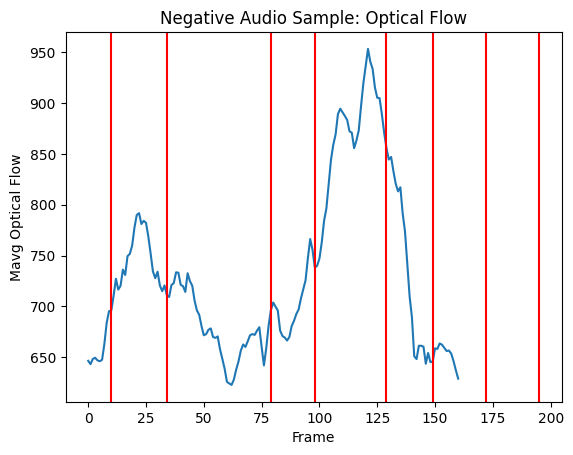

In [71]:
audio_sample = np.array(feat_audio[1])
optical_flow_audio = calculate_optical_flow_euclidean(audio_sample)
optical_flow_audio = moving_average(optical_flow_audio, window_size=20)

plt.plot(optical_flow_audio)
for peak in peak_index_final:
  plt.axvline(peak, ymin=0, ymax=1, color='r')
plt.title('Negative Audio Sample: Optical Flow')
plt.xlabel('Frame')
plt.ylabel('Mavg Optical Flow')
plt.show()

array([ 10,  34,  79,  98, 129, 149, 172, 195])

[656.9909307861328,
 744.9128801981609,
 678.5495701768663,
 701.2614730031867,
 864.7457118864984,
 738.0555789184571,
 652.1530254364014,
 0,
 0]

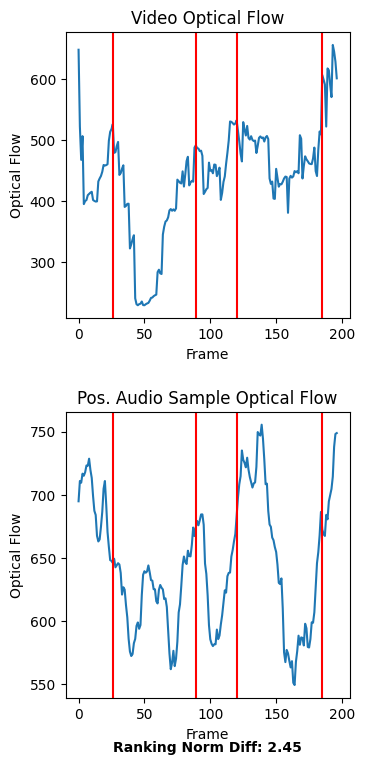

In [202]:
fig, axes = plt.subplots(2, 1, sharey=False, figsize=(4, 8))
axes[0].plot(optical_flow_video)
axes[0].set_title('Video Optical Flow')
axes[0].set_xlabel('Frame')
axes[0].set_ylabel('Optical Flow')

axes[1].plot(optical_flow_audio_pos)
axes[1].set_title('Pos. Audio Sample Optical Flow')
axes[1].set_xlabel('Frame')
axes[1].set_ylabel('Optical Flow')


for peak in segments:
  axes[0].axvline(peak, ymin=0, ymax=1, color='r')
  axes[1].axvline(peak, ymin=0, ymax=1, color='r')

axes[1].text(0.5, -0.15, f'Ranking Norm Diff: {norm_diff_pos}', ha='center', fontweight='bold', va='top', transform=axes[1].transAxes)
plt.tight_layout(pad=2)
plt.savefig('Segment1.png')

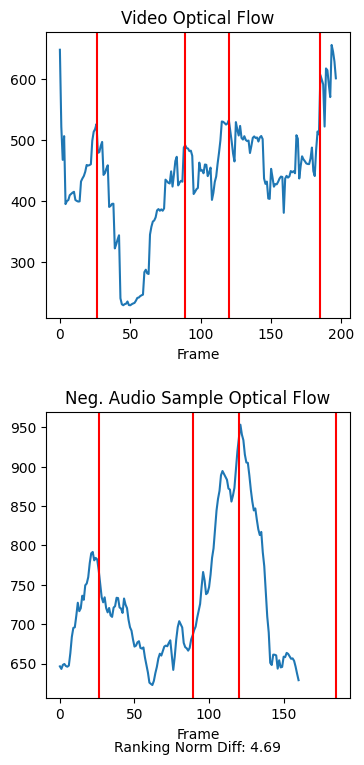

In [203]:
fig, axes = plt.subplots(2, 1, sharey=False, figsize=(4, 8))
axes[0].plot(optical_flow_video)
axes[0].set_title('Video Optical Flow')
axes[0].set_xlabel('Frame')

axes[1].plot(optical_flow_audio_neg1)
axes[1].set_title('Neg. Audio Sample Optical Flow')
axes[1].set_xlabel('Frame')


for peak in segments:
  axes[0].axvline(peak, ymin=0, ymax=1, color='r')
  axes[1].axvline(peak, ymin=0, ymax=1, color='r')

axes[1].text(0.5, -0.15, f'Ranking Norm Diff: {norm_diff_neg1}', ha='center', va='top', transform=axes[1].transAxes)
plt.tight_layout(pad=2)
plt.savefig('Segment2.png')

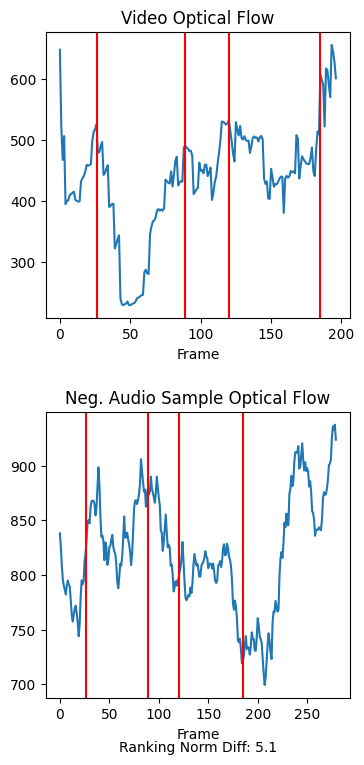

In [204]:
fig, axes = plt.subplots(2, 1, sharey=False, figsize=(4, 8))
axes[0].plot(optical_flow_video)
axes[0].set_title('Video Optical Flow')
axes[0].set_xlabel('Frame')

axes[1].plot(optical_flow_audio_neg2)
axes[1].set_title('Neg. Audio Sample Optical Flow')
axes[1].set_xlabel('Frame')


for peak in segments:
  axes[0].axvline(peak, ymin=0, ymax=1, color='r')
  axes[1].axvline(peak, ymin=0, ymax=1, color='r')

axes[1].text(0.5, -0.15, f'Ranking Norm Diff: {norm_diff_neg2}', ha='center', va='top', transform=axes[1].transAxes)
plt.tight_layout(pad=2)
plt.savefig('Segment3.png')

In [134]:
# Calculate optical flow using cosine similarity
optical_flow_video = calculate_optical_flow_euclidean(rgb_frames)
optical_flow_video = moving_average(optical_flow_video, window_size=20)

optical_flow_audio_pos = calculate_optical_flow_euclidean(audio_sample_pos)
optical_flow_audio_pos = moving_average(optical_flow_audio_pos, window_size=20)

optical_flow_audio_neg1 = calculate_optical_flow_euclidean(audio_sample_neg1)
optical_flow_audio_neg1 = moving_average(optical_flow_audio_neg1, window_size=20)

optical_flow_audio_neg2 = calculate_optical_flow_euclidean(audio_sample_neg2)
optical_flow_audio_neg2 = moving_average(optical_flow_audio_neg2, window_size=20)

# Segment the video based on regime changes in optical flow
segments = optical_flow_segments(optical_flow_video, max_segments=4)

segment_ranks_video = rank_averages(compute_segment_means(segments, optical_flow_video))
segment_ranks_audio_pos = rank_averages(compute_segment_means(segments, optical_flow_audio_pos))
segment_ranks_audio_neg1 = rank_averages(compute_segment_means(segments, optical_flow_audio_neg1))
segment_ranks_audio_neg2 = rank_averages(compute_segment_means(segments, optical_flow_audio_neg2))

print(segment_ranks_video)
print(segment_ranks_audio_pos)
print(segment_ranks_audio_neg1)
print(segment_ranks_audio_neg2)

norm_diff_pos = round(np.linalg.norm(segment_ranks_video-segment_ranks_audio_pos), 2)
norm_diff_neg1 = round(np.linalg.norm(segment_ranks_video-segment_ranks_audio_neg1), 2)
norm_diff_neg2 = round(np.linalg.norm(segment_ranks_video-segment_ranks_audio_neg2), 2)

print(norm_diff_pos)
print(norm_diff_neg1)
print(norm_diff_neg2)